In [1]:
!pip install tensorflow==2.10.0

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
!pip install transformers
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.2 MB/s eta 0:00:00


In [3]:
#load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [4]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
# Split data into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Tokenize the input texts
#X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
#X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
#with open('X_train_tokenized_BERTimbau_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

#with open('X_test_tokenized_BERTimbau_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_test_tokenized, f)

# Load tokenized data
with open('X_train_tokenized_BERTimbau_base_cased.pkl', 'rb') as f:
  X_train_tokenized = pickle.load(f)

with open('X_test_tokenized_BERTimbau_base_cased.pkl', 'rb') as f:
  X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model for sequence classification
from transformers import TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
x = Dropout(0.5)(x)  # Add a dropout layer for regularization

output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

Epoch 1/10


791/791 [==============================] - 1461s 2s/step - loss: 0.2087 - accuracy: 0.9061 - val_loss: 0.1349 - val_accuracy: 0.9401
Epoch 2/10
791/791 [==============================] - 1429s 2s/step - loss: 0.0992 - accuracy: 0.9563 - val_loss: 0.1327 - val_accuracy: 0.9470
Epoch 3/10
791/791 [==============================] - 1423s 2s/step - loss: 0.0593 - accuracy: 0.9743 - val_loss: 0.1575 - val_accuracy: 0.9437
Epoch 4/10
791/791 [==============================] - 1403s 2s/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 0.1689 - val_accuracy: 0.9435
Epoch 5/10
791/791 [==============================] - 1402s 2s/step - loss: 0.0195 - accuracy: 0.9935 - val_loss: 0.2053 - val_accuracy: 0.9430


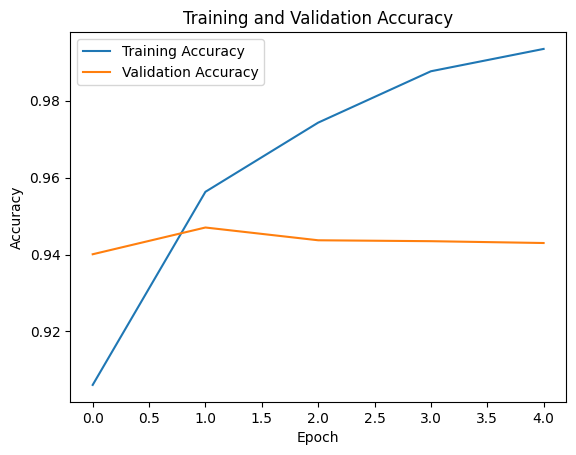

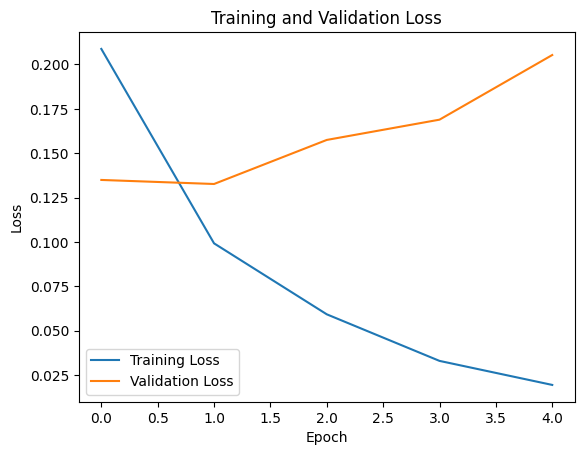

In [8]:
plot_train_val_loss_acc(history)

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

198/198 [==============================] - 111s 559ms/step - loss: 0.1327 - accuracy: 0.9470
Test loss: 0.133, Test accuracy: 0.947


396/396 [==============================] - 116s 285ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      6285
           1       0.94      0.96      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648



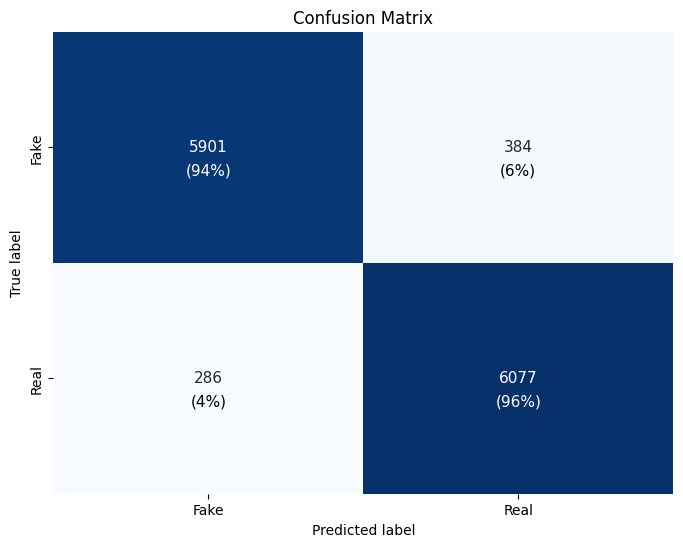

In [10]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

# Compute normalized values
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], annot_kws={"fontsize": 11})

# Add normalized values below the actual values
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        text_color = 'black' if conf_mat_norm[i, j] < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.6, f'({conf_mat_norm[i, j]:.0%})', ha='center', va='center', color=text_color, fontsize=11)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#model.save('dir_model_BERTmulti_92_portuguese')

In [ ]:
# Define the custom objects
custom_objects = {
    'TFBertModel': TFBertModel,
}

# Load the model with custom objects
model = load_model('dir_model_DistilBERT_92_portuguese', custom_objects=custom_objects)

In [ ]:
# Preprocess the text
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
max_length = 128  # Max sequence length used during training
text = 'Médicos e farmacêuticos dizem que está a aumentar o risco de se morrer de uma doença que não a covid-19 Especialistas alertam que as medidas extraordinárias de confinamento produzem efeitos mais gravosos para a sociedade do que a pandemia. Numa carta aberta, médicos e farmacêuticos manifestaram-se contra a tomada de medidas extraordinárias de confinamento para combater a pandemia. Os profissionais da saúde alertam que estas medidas produzem efeitos mais gravosos para a sociedade do que a própria covid-19. Os especialistas defendem que a pandemia continue a ser prioritária, mas com outras medidas de combate. Pedem medidas adequadas, como a aceleração da vacinação, simplificando o processo, e apelam também para que se envolvam agentes da sociedade civil, como por exemplo as farmácias, de forma a aumentar rapidamente a cobertura vacinal. Médicos e farmacêuticos defendem também o aperfeiçoamento da vigilância epidemiológica, que consideram estar a ser um insucesso no país. Sublinham ainda que, nos últimos 14 dias, a taxa de mortalidade pelo SARS-Cov-2 foi de 0,03 por 100 mil habitantes contra uma taxa de mortalidade por outras doenças e causas de morte de 2,7 por 100 mil.'
text_tokens = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')

# Make the prediction
prediction = model.predict(text_tokens['input_ids'])[0][0]

# Convert prediction to a label
label = 1 if prediction >= 0.5 else 0
confidence = prediction if prediction >= 0.5 else 1 - prediction

print(f"Prediction: {label}")
print(f"Confidence: {confidence:.4f}")

1/1 [==============================] - 2s 2s/step
Prediction: 1
Confidence: 0.7771
